In [1]:
# предварительно в консоли прописал brew install gdal
# pip install geopandas rasterio geopy 

import glob
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc

import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS
import geopandas as gpd
import cartopy.crs as ccrs
from geopy.distance import geodesic
from shapely.geometry import Polygon


In [2]:
from FFP_Python import calc_footprint_FFP as fp
from FFP_Python import calc_footprint_FFP_climatology as fpc

## Footprints

In [3]:
# Считывает csv-файлы по шаблону и объединяет их в один DataFrame
def create_df(file_pattern, sep=';'):
    
    file_list = glob.glob(file_pattern)
    file_list = sorted(file_list)

    combined_df = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name, sep=sep)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df
    
# позволяет получить координату новой точки, лежащей в скольких-то метрах от стартовой 
def new_point(lat, lon, delta_lat, delta_lon, xy=False):
    # (lat, lon) - Координаты точки (широта, долгота) в градусах
    # (delta_lat, delta_lon) - Cмещение точки по (широте, долготе) в метрах

    # Рассчитываем координаты точки смещения по широте
    new_lat = lat + (delta_lat / geodesic((lat, lon), (lat + 1, lon)).meters)

    # Рассчитываем координаты точки смещения по долготе
    new_lon = lon + (delta_lon / geodesic((lat, lon), (lat, lon + 1)).meters)
    
    if xy:
        return (new_lon, new_lat)
    else:
        return (new_lat, new_lon)


def calculate_coriolis_parameter(latitude):
    omega = 7.2921e-5 # угловая скорость вращения Земли  рад/сек
    f = 2 * omega * np.sin(np.radians(latitude))
    return f


def select_variables_for_fp_calculation(df):
    datetime = pd.to_datetime(df['date'] + ' ' + df['time'])

    df = df[['wind_speed', 'wind_dir','(z-d)/L', 
         'L', 'u*', 'u_var', 'v_var']].astype(float)
    
    df.index = datetime
    df['datetime'] = datetime


    # f = calculate_coriolis_parameter(60.89142435)
    # df['h'] = (-1 + (1 + 2.28 * df['u*'] / (df['L'] * f)) ** (1/2)) * df['L'] / 3.8
    # df.loc[df['(z-d)/L']<0,'h'] = 1000
    # df['sigmav'] = (df['u_var']+df['v_var'])**(1/2)

    # df = df[df['u*']>0.1]
    
    df.dropna(inplace=True)
    return df

In [40]:
# name = 'bek_30m'
# input_files = './input/bek/30/*.csv'
# output_path = './output/bek/30/'
# tower_lat = 56.4808722197168
# tower_lon = 85.1015260601068
# tower_h = 30

# name = 'imces_bdmk_30m'
# input_files = './input/imces/bdmk/30/*.csv'
# output_path = './output/imces/bdmk/30/'
# tower_lat = 56.4749440905583
# tower_lon = 85.0543485585687
# tower_h = 30

# name = 'imces_bdmk_40m'
# input_files = './input/imces/bdmk/40/*.csv'
# output_path = './output/imces/bdmk/40/'
# tower_lat = 56.4749440905583
# tower_lon = 85.0543485585687
# tower_h = 40

# name = 'imces_mezo_30m'
# input_files = './input/imces/mezo/30/*.csv'
# output_path = './output/imces/mezo/30/'
# tower_lat = 56.4757084256941
# tower_lon = 85.054697213036
# tower_h = 30

name = 'oblcom_30m'
input_files = './input/oblcom/30/*.csv'
output_path = './output/oblcom/30/'
tower_lat = 56.4671832881314
tower_lon = 84.9574514166707
tower_h = 30


df = create_df(input_files)
# print(*df.columns, sep='\n')

df['data'] = pd.to_datetime(df.data, dayfirst=True)

# f = calculate_coriolis_parameter(tower_lat)
# df['h_abl'] = (-1 + (1 + 2.28 * df.u_star / (df.L * f)) ** (1/2)) * df.L / 3.8
# df.loc[tower_h/df.L<0,'h_abl'] = 1000
df['h_abl'] = 1000
df['std_u'] = df.uu**(0.5)

df = df[['data','Vvec','D','std_u','u_star','L', 'h_abl']]
df = df[df['u_star'] > 0.1]
# df = df[df['L'] >= -tower_h/15.5]

df['z'] = tower_h
df

,data,Vvec,D,std_u,u_star,L,h_abl,z
0,2024-07-31 23:40:00,1.467119,213.061997,0.641151,0.152747,277.610179,1000,30
1,2024-08-01 00:00:00,1.611281,219.686240,0.727185,0.155032,857.108920,1000,30
2,2024-08-01 00:20:00,1.714161,212.791870,0.773094,0.186414,199.747999,1000,30
3,2024-08-01 00:40:00,1.517152,205.930219,0.567022,0.165892,-50.384961,1000,30
4,2024-08-01 01:00:00,0.884551,213.816371,0.492042,0.115257,-21.278070,1000,30
...,...,...,...,...,...,...,...,...
6175,2024-10-31 21:40:00,1.260192,273.485002,0.292591,0.154531,-51.174137,1000,30
6176,2024-10-31 22:00:00,1.188374,270.929065,0.289826,0.179177,-111.671826,1000,30
6177,2024-10-31 22:20:00,0.759268,275.486674,0.272269,0.190054,-38.476500,1000,30
6178,2024-10-31 22:40:00,0.806118,255.680875,0.360630,0.290425,-104.566959,1000,30


In [41]:
domain = [-1500,1500,-1500,1500] # Domain size as an array of [xmin xmax ymin ymax] [m].
dx = 3
lon_ul, lat_ul = new_point(tower_lat, tower_lon, domain[3], domain[0], xy=True)
lon_lr, lat_lr = new_point(tower_lat, tower_lon, domain[2], domain[1], xy=True)
crs = CRS.from_epsg(4326)  # 'EPSG:4326'

footprint = fpc.FFP_climatology(zm = list(df.z), 
                                z0 = None, 
                                umean = list(df.Vvec),
                                wind_dir = list(df.D), 
                                h = list(df.h_abl), 
                                ol = list(df.L), 
                                sigmav = list(df.std_u),
                                ustar = list(df.u_star), 
                                dx = dx, 
                                domain = domain,
                                rslayer = False,
                                smooth_data = False,
                                crop = False, 
                                verbosity = 2,
                                fig = False)

    
# Конвертирование наибольшего контура футпринта (обычно 80%) в координаты и сохранение в shp формате
coordinates = [new_point(tower_lat, tower_lon, y, x, xy=True) for y, x in zip(footprint['yr'][-1], footprint['xr'][-1])] # Преобразуем расстояние от мачты в координаты
polygon = Polygon(coordinates)  # Создание полигона с использованием координат
gdf = gpd.GeoDataFrame(geometry=[polygon])  # Создание геопандас GeoDataFrame с полигоном
gdf.crs = crs  # Установка системы координат
file_path = f"{output_path}{name}_clim_{int(footprint['rs'][-1]*100)}.shp"
gdf.to_file(file_path) # Сохранение GeoDataFrame в файле .shp

# Сохранение функции распределения футпринта в tif формате
data = footprint['fclim_2d'][::-1]
height, width = data.shape
transform = from_bounds(lon_ul, lat_lr, lon_lr, lat_ul, width, height) 
file_path = f"{output_path}{name}_clim_{domain[1]-domain[0]}x{domain[3]-domain[2]}m_{dx}m.tif"
with rasterio.open(file_path, 'w', driver='GTiff', height=height, width=width, count=1,
                   dtype=data.dtype, crs=crs, transform=transform, nodata=None) as dst:
    dst.write(data, 1)
    



Alert(0014):
 No valid z0 passed, using umean.
 Execution continues.

Calculating footprint  1  of  5928

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -15.5.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.
Calculating footprint  297  of  5928

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -15.5.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -15.5.
 Execution continues.

Error(0016):
 At least one required input is invalid. Skipping current footprint.
 Execution continues.
Calculating footprint  593  of  5928
Calculating footprint  889  of  5928

Error(0007):
 zm/ol (measurement height to Obukhov length ratio) must be equal or larger than -

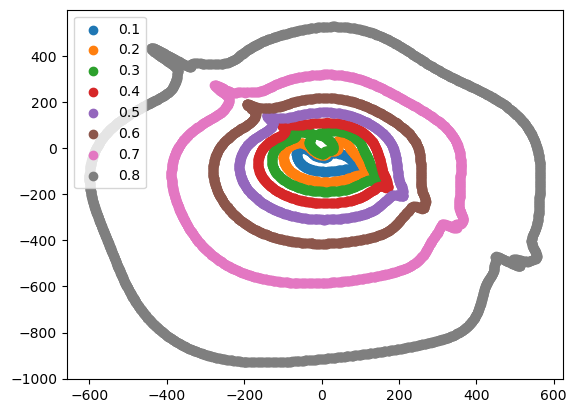

In [43]:
for xr, yr, rs in zip(footprint['xr'], footprint['yr'], footprint['rs']):
    plt.scatter(xr, yr, label = rs)
plt.legend()
